## Import and define common functions

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import pylab as plt
import h5py
import pycbc.conversions as convert
import seaborn as sns
import numpy as np
from matplotlib import lines as mlines
import corner
import os
import pandas as pd
from matplotlib.patches import PathPatch
from pycbc.distributions.utils import prior_from_config
import pycbc
from pycbc.workflow import WorkflowConfigParser
from scipy.stats import gaussian_kde
import time
from pycbc.inference import io
from pycbc.io import FieldArray
import deepdish as dd
import matplotlib.patches as mpatches
import matplotlib

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import matplotlib as mpl

In [3]:
mpl.rcParams['font.family'] = 'serif'

In [4]:
def mchirp(M,q):
    m1 = convert.mass1_from_mtotal_q(M, q)
    m2 = convert.mass2_from_mtotal_q(M, q)
    return(convert.mchirp_from_mass1_mass2(m1, m2))

In [5]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/'
run_dir_base = os.path.join(base_dir, 'injections/ICTS_sims')
plot_dir = os.path.join(base_dir, 'plots')
ecc_spin_run_nums = {'PS': 'run01',
                     'eAS': 'run02'}

In [6]:
pycbc_to_metadata_dict = {
    'chi_eff': 'chi_eff_ref',
    'chi_p': 'chi_p_ref',
    'distance': 'DL',
    'mass1': 'm1',
    'mass2': 'm2',
    'mchirp': 'm_chirp',
    'mtotal': 'M',
    'polarization': 'pol',
    'eccentricity': 'Eccentricity'
}

keys_not_in_metadata = {
    'coa_phase': 0, 
    'delta_tc': 0,
    'loglikelihood': None,
    'logwt': None
}

In [7]:
with h5py.File('/home/divyajyoti/ACADEMIC/Projects/IITM_GW/Eccentric_Population/eccentric_pe/injections/ICTS_sims/Lev2/EccContPrecDiff003/zero_noise/inj1/run01/posterior.hdf', 'r') as f:
    print(f['samples']['mchirp'][:])
    print(f['samples'].keys())

[34.85056013 35.8615798  33.44073958 ... 34.76891839 34.4056409
 35.95279569]
<KeysViewHDF5 ['chi_eff', 'chi_p', 'coa_phase', 'dec', 'delta_tc', 'distance', 'eta', 'inclination', 'loglikelihood', 'logwt', 'mass1', 'mass2', 'mchirp', 'mtotal', 'polarization', 'q', 'ra', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin2_a', 'spin2_azimuthal', 'spin2_polar']>


In [8]:
def get_param_inj_val_from_metadata(meta_file, param, round_to=4):
    with open(meta_file, 'r') as f:
        metadata_text = f.read().splitlines()

    while(1):
        try:
            metadata_text.remove('')
        except ValueError:
            break
    
    metadata_text = [line.strip().replace('\\t', '') for line in metadata_text]
    for line in metadata_text:
        if '=' not in line or '===>' in line:
            continue
        param_metadata, val = ''.join(line.split()).split('=')
        return_val = val
        if param == 'spin1z' and param_metadata == 'ChiA_ref':
            return_val = eval(val)[-1]
            break
        elif param == 'spin2z' and param_metadata == 'ChiB_ref':
            return_val = eval(val)[-1]
            break
        elif param_metadata == param:
            break
        elif param in pycbc_to_metadata_dict.keys():
            if param_metadata == pycbc_to_metadata_dict[param]:
                break
    else:
        raise ValueError(f'{param} value not found')
    return(round(float(return_val), round_to))

In [9]:
def get_data(param, lev, ecc_spin_config, sim, inj='inj1'):
    posterior_file_path = os.path.join(run_dir_base, lev, sim, 'zero_noise', 
                                       inj, ecc_spin_run_nums[ecc_spin_config], 
                                       'posterior.hdf')
    metadata_file_path = os.path.join(run_dir_base, lev, sim, 'zero_noise', inj, 'metadata.txt')
    with h5py.File(posterior_file_path, 'r') as f:
        if param == 'SNR':
            param_data = convert.snr_from_loglr(f['samples']['loglikelihood']-f['samples'].attrs.get('lognl'))
        else:
            param_data = f['samples'][param][:]
    try:
        param_inj_val = get_param_inj_val_from_metadata(metadata_file_path, param)
    except ValueError:
        param_inj_val = None
    return(param_data, param_inj_val)

In [10]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

## Overview plots of all simulations

In [11]:
sims_at_highest_lev = {'names':[], 'meta_files':[], 'levs':[]}
for lev in ['Lev4', 'Lev3', 'Lev2']:
    sim_list = list(os.walk(os.path.join(run_dir_base, lev)))[0][1]
    sim_list.sort()
    for sim in sim_list:
        if sim not in sims_at_highest_lev['names']:
            sims_at_highest_lev['names'].append(sim)
            sims_at_highest_lev['meta_files'].append(os.path.join(run_dir_base, 
                                                                  lev, 
                                                                  sim, 
                                                                  'zero_noise',
                                                                  'inj1',
                                                                  'metadata.txt'))
            sims_at_highest_lev['levs'].append(lev)

In [12]:
inj_vals = {
    'sim_names': [],
    'mchirp': [],
    'chi_eff': [],
    'chi_p': [],
    'mtotal': [],
    'q': [],
    'eccentricity': []
}
for sim, meta_file in zip(sims_at_highest_lev['names'], sims_at_highest_lev['meta_files']):
    inj_vals['sim_names'].append(sim)
    for param in list(inj_vals.keys())[1:]:
        inj_vals[param].append(get_param_inj_val_from_metadata(meta_file, param))
inj_vals_df = pd.DataFrame(inj_vals).set_index('sim_names')

In [13]:
def create_scatter_plots(df, x, y, colr):
    plt.scatter(df[x], df[y], c=df[colr])
    plt.colorbar(label=colr)
    plt.grid()
    plt.xlabel(x)
    plt.ylabel(y)

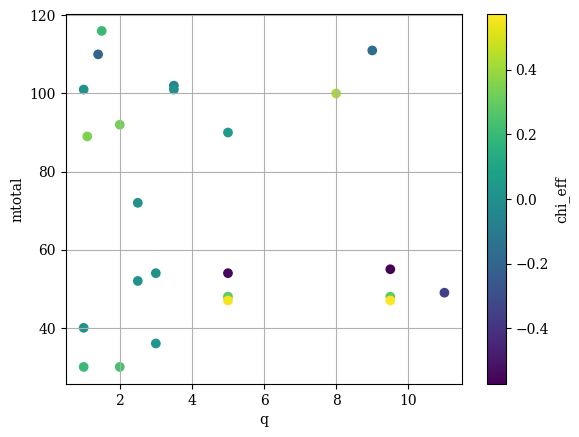

In [14]:
create_scatter_plots(inj_vals_df, 'q', 'mtotal', 'chi_eff')

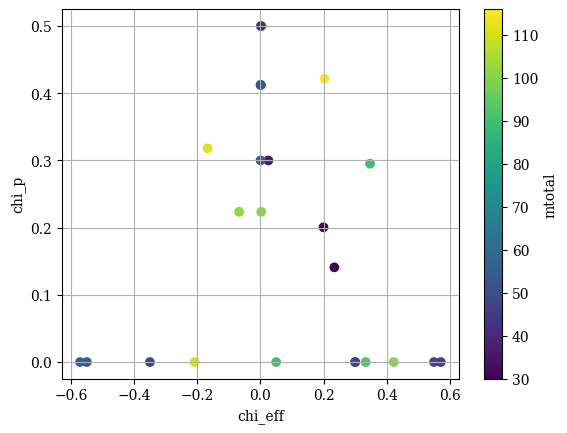

In [15]:
create_scatter_plots(inj_vals_df, 'chi_eff', 'chi_p', 'mtotal')

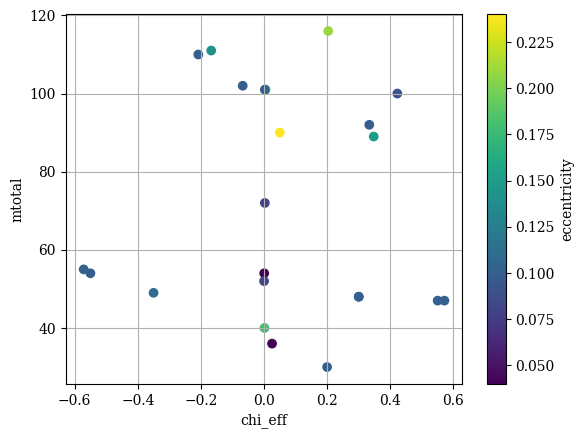

In [16]:
create_scatter_plots(inj_vals_df, 'chi_eff', 'mtotal', 'eccentricity')

,mchirp,chi_eff,chi_p,mtotal,q,eccentricity
sim_names,,,,,,
EccContPrecDiff001,13.1857,0.0253,0.3000,36.0,3.0,0.04
EccContPrecDiff003,35.5784,-0.0676,0.2236,102.0,3.5,0.10
EccContPrecDiff004,38.6868,0.3474,0.2952,89.0,1.1,0.15
EccContPrecDiff005,43.9628,0.0046,0.4999,101.0,1.0,0.18
EccContPrecDiff006,49.2702,0.2033,0.4217,116.0,1.5,0.21
EccContPrecDiff007,27.7469,0.0025,0.4123,72.0,2.5,0.08
EccContPrecDiff008,17.4110,0.0013,0.5000,40.0,1.0,0.18
EccPrecDiff002,13.0583,0.1997,0.2005,30.0,1.0,0.10
ICTSEccParallel01,19.7786,0.0005,0.3000,54.0,3.0,0.04


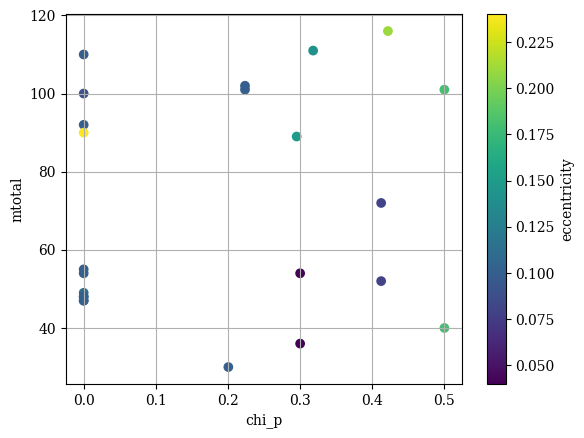

In [19]:
create_scatter_plots(inj_vals_df, 'chi_p', 'mtotal', 'eccentricity')
inj_vals_df[inj_vals_df['chi_p']>0.1]

## PE results

In [18]:
pe_data = {'PS':{},
           'eAS':{}}
for spin_config in pe_data.keys():
    pe_data[spin_config]['sim_name'] = []
    for param in list(inj_vals_df.keys()) + ['loglikelihood', 'logwt', 'SNR']:
        if param == 'eccentricity' and spin_config == 'PS':
            continue
        if param == 'chi_p' and spin_config == 'eAS':
            continue
        pe_data[spin_config][param] = []
    for sim, lev in zip(sims_at_highest_lev['names'], sims_at_highest_lev['levs']):
        pe_data[spin_config]['sim_name'].append(sim)
        for param in list(pe_data[spin_config].keys())[1:]:
            pe_data[spin_config][param].append(get_data(param, lev, spin_config, sim)[0])
pe_data_df = {}
for key in pe_data.keys():
    pe_data_df[key] = pd.DataFrame(pe_data[key]).set_index('sim_name').T

In [19]:
def get_errors(data, truth):
    median = np.percentile(data, 50)
    stat_error = np.percentile(data, 95) - np.percentile(data, 5)
    sys_error = abs(median - truth)
    rel_sys_error = sys_error/truth
    rel_stat_error = stat_error/truth
    return(median, stat_error, sys_error, rel_stat_error, rel_sys_error)

In [20]:
pe_data_df['eAS']['EccContPrecDiff001'].keys()

Index(['mchirp', 'chi_eff', 'mtotal', 'q', 'eccentricity', 'loglikelihood',
       'logwt', 'SNR'],
      dtype='object')

In [21]:
inj_vals_df['mchirp']['EccContPrecDiff001']

np.float64(13.1857)

In [22]:
def pe_plot_scatter(param, ecc_spin_config, data_df=pe_data_df, inj_df=inj_vals_df, 
                    plot_rel_errors=True, plot_snrs=True):
    stat_errs = []
    sys_errs = []
    truths = []
    snrs = []
    for sim in data_df[ecc_spin_config].keys():
        truth = inj_vals_df[param][sim]
        m, st, sy, rel_st, rel_sy = get_errors(data_df[ecc_spin_config][sim][param], truth)
        snr_idx, m_closest = find_nearest(data_df[ecc_spin_config][sim][param], m)
        snr = data_df[ecc_spin_config][sim]['SNR'][snr_idx]
        snrs.append(snr)
        if rel_st > 0.3 or rel_sy > 0.3:
            print(sim)
        if plot_rel_errors:
            stat_errs.append(rel_st)
            sys_errs.append(rel_sy)
            ylabl = '$\Delta$('+param+')/'+param
            clabl = 'relative bias'
        else:
            stat_errs.append(st)
            sys_errs.append(sy)
            ylabl = '$\Delta$('+param+')'
            clabl = 'bias'
        if plot_snrs:
            size = snrs
        else:
            size=20
        truths.append(truth)
    #plt.scatter(sys_errs, truths, c=stat_errs, s=size, norm=matplotlib.colors.LogNorm())
    plt.scatter(sys_errs, truths, c=stat_errs, s=size)
    plt.colorbar(label=ylabl)
    plt.xlabel(param)
    plt.ylabel(clabl)
    plt.title(ecc_spin_config)
    plt.grid()

ICTSEccParallel06
ICTSEccParallel14


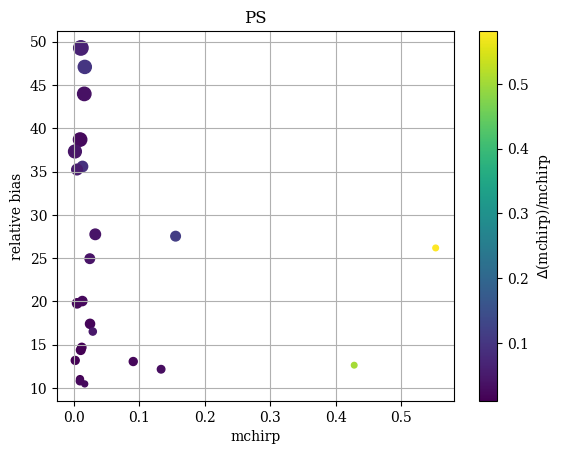

In [23]:
pe_plot_scatter('mchirp', 'PS')

EccContPrecDiff003
ICTSEccParallel03
ICTSEccParallel06
ICTSEccParallel08
ICTSEccParallel14


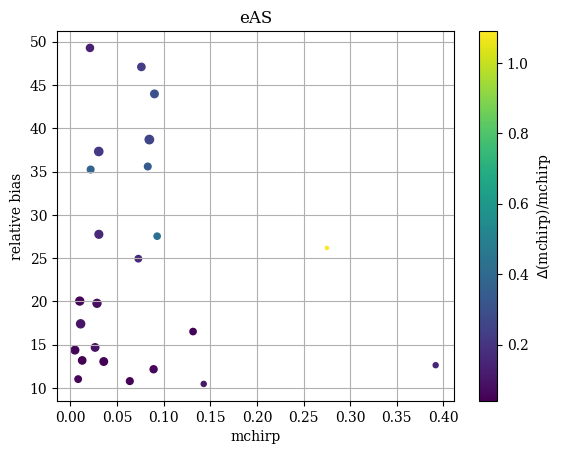

In [24]:
pe_plot_scatter('mchirp', 'eAS')

EccContPrecDiff001
EccContPrecDiff003
EccContPrecDiff004
EccContPrecDiff005
EccContPrecDiff006
EccContPrecDiff007
EccContPrecDiff008
EccPrecDiff002
ICTSEccParallel01
ICTSEccParallel02
ICTSEccParallel03
ICTSEccParallel04
ICTSEccParallel05
ICTSEccParallel06
ICTSEccParallel07
ICTSEccParallel08
ICTSEccParallel10
ICTSEccParallel12
ICTSEccParallel17
ICTSEccParallel13
ICTSEccParallel14
ICTSEccParallel15
ICTSEccParallel16


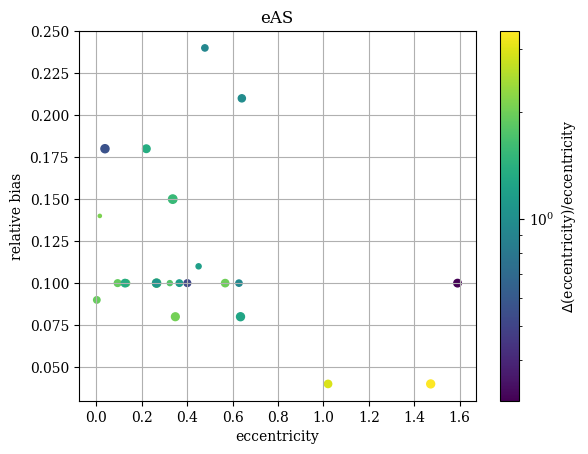

In [300]:
pe_plot_scatter('eccentricity', 'eAS')

ICTSEccParallel06
ICTSEccParallel17
ICTSEccParallel13


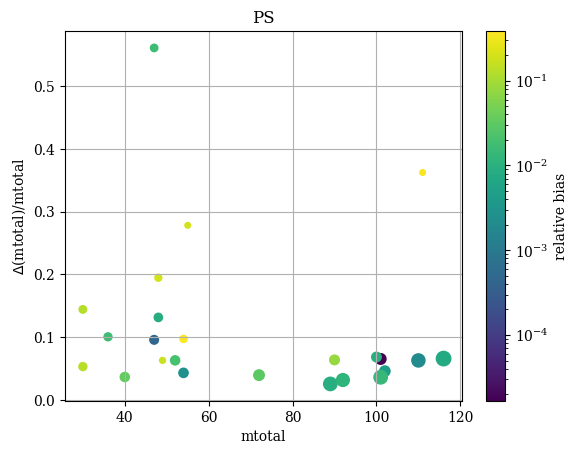

In [285]:
pe_plot_scatter('mtotal', 'PS')

In [208]:
for sim in sims_in_q(q):
    print(sim, table_e20[sim]['e0'])

BBH_1167 0.0
BBH_1364 0.104
BBH_1365 0.125
BBH_1366 0.197
BBH_1367 0.197
BBH_1368 0.197
BBH_1369 0.322
BBH_1370 0.322


In [212]:
mixed_NS_AS_inj_list = ['BBH_1167', 
                        'AS_0.0', 'AS_0.1', 
                        'BBH_1364', 'BBH_1365', 'BBH_1366', 'BBH_1367', 'BBH_1368', 
                        'AS_0.2', 'AS_0.3',
                        'BBH_1369', 'BBH_1370']

In [232]:
def get_samples_param_dual_injections_dual_recoveries(param, inj1_spin1, inj1_spin2, inj2_spin1, inj2_spin2, q):
    
    param_samples_all = []
    inj_spin_list = []
    inj_ecc_list = []

    for iter in mixed_NS_AS_inj_list:
        if 'BBH' in iter:
            inj = 'NS'
            spin_list = [inj1_spin1, inj1_spin2]
            load_paths = pos_files[iter]
            ecc_value = table_e20[iter]['e0']
        else:
            inj = 'AS'
            spin_list = [inj2_spin1, inj2_spin2]
            ecc_value = eval(iter.split('_')[-1])
            if ecc_value==0 or ecc_value==0.1:
                load_paths = old_paths['q_{}'.format(float(q))][ecc_value]
            else:
                load_paths = 'custom'
        for spin_type in spin_list:
            if load_paths=='custom':
                param_samples = dd.io.load(get_file_path(q, ecc_value, spin_type))['samples'][param]
            else:
                param_samples = dd.io.load(load_paths[spin_type])['samples'][param]
            
            param_samples_all.append(param_samples)
            inj_spin_list.append(inj+'-'+spin_type)
        inj_ecc_list.append(ecc_value)

    return(param_samples_all, inj_spin_list, inj_ecc_list)

In [233]:
mixed_samples_q2, inj_spin_list, inj_ecc_list = get_samples_param_dual_injections_dual_recoveries('mchirp', 'NS', 'eNS', 'AS', 'eAS', 2)

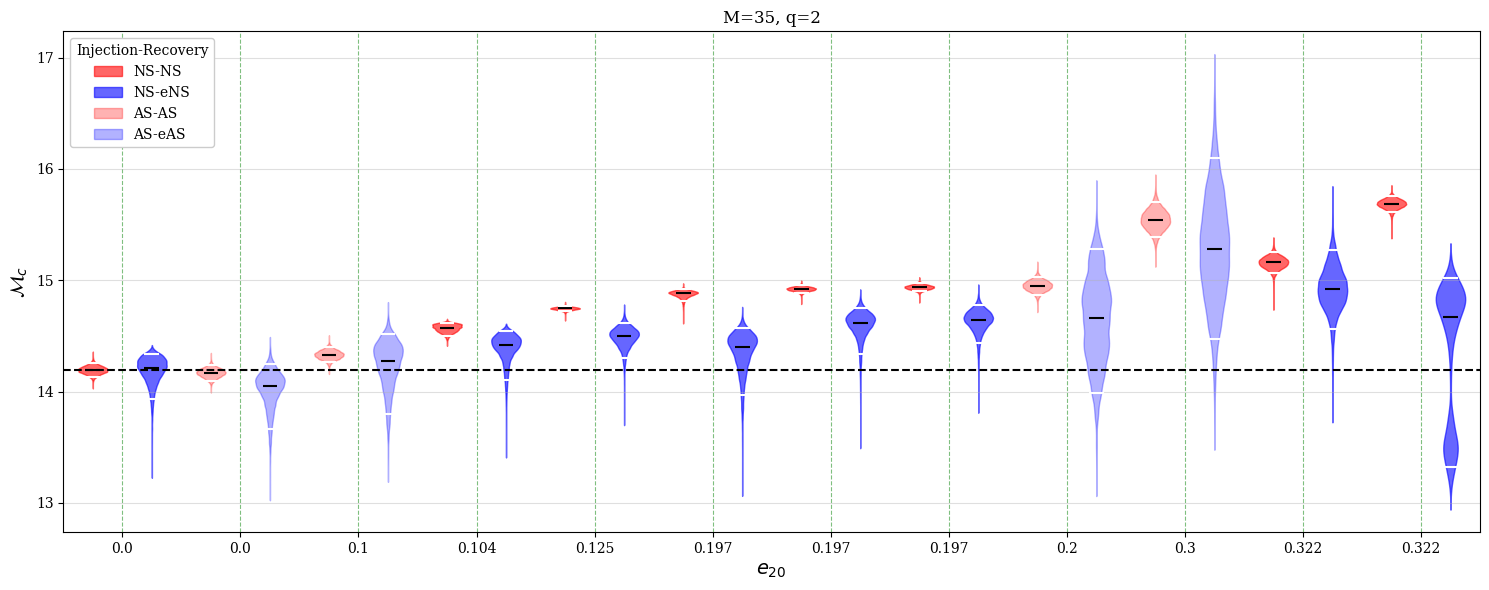

In [241]:
q=2

plt.figure(figsize=(15,6))
#plt.figure()
sim_colors = []
sim_alphas = []

for inj_spin_type in inj_spin_list:
    if 'NS' in inj_spin_type:
        sim_alphas.append(0.6)
    elif 'AS' in inj_spin_type:
        sim_alphas.append(0.3)
    if 'e' in inj_spin_type:
        sim_colors.append('blue')
    else:
        sim_colors.append('red')

violin_parts = plt.violinplot(mixed_samples_q2, quantiles=[[0.05, 0.95]]*len(mixed_samples_q2), 
                              showextrema=0, showmedians=True)
for pc, color, alph in zip(violin_parts['bodies'], sim_colors, sim_alphas):
    pc.set_color(color)
    pc.set_alpha(alph)
    
violin_parts['cquantiles'].set_color('white')
violin_parts['cmedians'].set_color('k')
#plt.axhline(0.1, color='k', ls='--')
plt.axhline(mchirp(35, q), color='k', ls='--')
plt.xticks([y for y in np.arange(1.5, len(mixed_samples_q2), 2)],
                  labels=inj_ecc_list);
plt.ylabel('$\mathcal{M}_c$', fontsize=14)
plt.xlabel('$e_{20}$', fontsize=14)

#cmappable = ScalarMappable(Normalize(min(event_SNRs), max(event_SNRs)), cmap=plt.cm.plasma)
#plt.colorbar(cmappable, label='SNR')

legend_labels = []
for alph, inj_spin in zip([0.6, 0.3], ['NS', 'AS']):
    for color, rec_spin in zip(['red', 'blue'], [inj_spin, 'e'+inj_spin]):
        legend_labels.append((mpatches.Patch(color=color, alpha=alph), inj_spin+'-'+rec_spin))
    
plt.legend(*zip(*legend_labels), loc=2, framealpha=1, title='Injection-Recovery')
plt.title('M=35, q={}'.format(q))
plt.grid(alpha=0.4, axis='y')
plt.grid(alpha=0.5, axis='x', ls='--', color='green')
#for position in np.arange(2.5, 24, 2):
#    plt.axvline(position, alpha=0.4, lw=0.5, color='grey')
plt.xlim(0.5,24.5)
plt.tight_layout()
plt.savefig(plot_dir+'violin_mchirp_inj_NS_AS_rec_XAS_TF2Ecc_q{}.pdf'.format(q))